In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import re
import sys
import glob
import codecs
import pathlib

from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import utils

In [3]:
sources_files = utils.get_sources_files()
text_folders = utils.get_text_folders()

print("Number of Sources Files: ", len(sources_files))
print("Number of Text Folders: ", len(text_folders))

Number of Sources Files:  49
Number of Text Folders:  129


In [ ]:
%%time

MAX_ARTICLES = 50
SOURCES_SET = sources_files

summary_stats, file_lookup = [], []
current_year, current_month = None, None
for i, sources_file in enumerate(SOURCES_SET, 1): 
    print(f"Source file ({i:>02}/{len(SOURCES_SET):>02}): {sources_file}... ", end="", flush=True)
    
    sources = utils.read_sources_file(sources_file)
    sources["month"] = sources["date"].dt.month
    sources["year"] = sources["date"].dt.year
    
    sources_groups = sources.groupby(["year", "month", "country"])
    for (year, month, country), country_df in sources_groups:
        success = True
        if (
            sources["year"].unique().shape[0] > 1 and
            (year != current_year or month != current_month)
        ):
            print(f"\n  {utils.format_year(year)}-{utils.format_month(month)}: ", end="", flush=True)
            current_year, current_month = year, month
            
        print(country, end=", ", flush=True)

        try:
            text_file_path = utils.get_text_file_path(text_folders, year, month, country)
        except:
            text_file_path = None
            success = False
            
        if text_file_path:
            try:
                text_data = utils.read_text_file(text_file_path)
            except:
                success = False
        
        file_lookup.append((year, month, country, sources_file, text_file_path, success))
        

        for publisher, publisher_df in country_df.groupby("website"):
            if success:
                to_export = publisher_df.merge(text_data, how="left", on="id")

                if to_export.shape[0] >= MAX_ARTICLES:
                    to_export = to_export.sample(MAX_ARTICLES)

                to_export["export_path"] = to_export.apply(utils.export_report, axis=1, 
                                                       path=utils.CLEAN_DATA_FOLDER)

            summary_stats.append((year, month, country, publisher, *utils.get_basic_summary_stats(publisher_df)))
        
    
    print()
    
summary_stats_df = pd.DataFrame(summary_stats, columns=["year", "month", "country", "publisher", "num_articles", "total_words"])
summary_stats_df.to_csv("data/summary_stats.csv", index=False)

file_lookup_df = pd.DataFrame(file_lookup, columns=["year", "month", "country", "source_file", "text_file", "success"])
file_lookup_df.to_csv("data/file_lookup.csv", index=False)

Source file (01/49): data\raw\now_sources_pt1.txt... 
  10-01: AU, BD, CA, GB, GH, HK, IE, IN, JM, KE, LK, MY, NG, NZ, PH, PK, SG, TZ, US, ZA, 
  10-02: AU, BD, CA, GB, GH, HK, IE, IN, JM, KE, LK, MY, NG, NZ, PH, PK, SG, TZ, US, ZA, 
  10-03: AU, BD, CA, GB, GH, HK, IE, IN, JM, KE, LK, MY, NG, NZ, PH, PK, SG, TZ, US, ZA, 
  10-04: AU, BD, CA, GB, GH, HK, IE, IN, JM, KE, LK, MY, NG, NZ, PH, PK, SG, US, ZA, 
  10-05: AU, BD, CA, GB, GH, HK, IE, IN, JM, KE, LK, MY, NG, NZ, PH, PK, SG, TZ, US, ZA, 
  10-06: AU, BD, CA, GB, GH, HK, IE, IN, JM, KE, LK, MY, NG, NZ, PH, PK, SG, TZ, US, ZA, 
  10-07: AU, BD, CA, GB, GH, HK, IE, IN, JM, KE, LK, MY, NG, NZ, PH, PK, SG, US, ZA, 
  10-08: AU, BD, CA, GB, GH, HK, IE, IN, JM, KE, LK, MY, NG, NZ, PH, PK, SG, TZ, US, ZA, 
  10-09: AU, BD, CA, GB, GH, HK, IE, IN, JM, KE, LK, MY, NG, NZ, PH, PK, SG, US, ZA, 
  10-10: AU, BD, CA, GB, GH, HK, IE, IN, JM, KE, LK, MY, NG, NZ, PH, PK, SG, TZ, US, ZA, 
  10-11: AU, BD, CA, GB, GH, HK, IE, IN, JM, KE, LK, MY, N

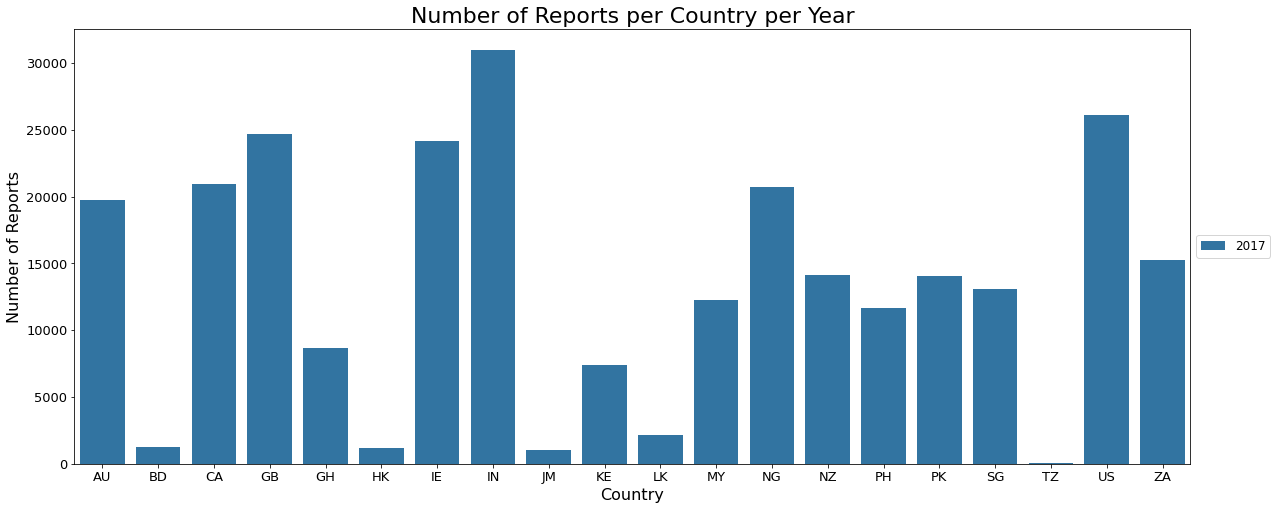

In [8]:
summary_by_country_by_year = summary_stats_df.groupby(["country", "year"])
summary_by_country_by_year = summary_by_country_by_year[["num_articles", "total_words"]]
summary_by_country_by_year = summary_by_country_by_year.sum().reset_index()

fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(
    x="country", 
    y="num_articles", 
    hue="year",
    data=summary_by_country_by_year,
    ax=ax
)

ax.set_xlabel("Country", fontsize=16)
ax.set_ylabel("Number of Reports", fontsize=16)
ax.set_title("Number of Reports per Country per Year", fontsize=22)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12);

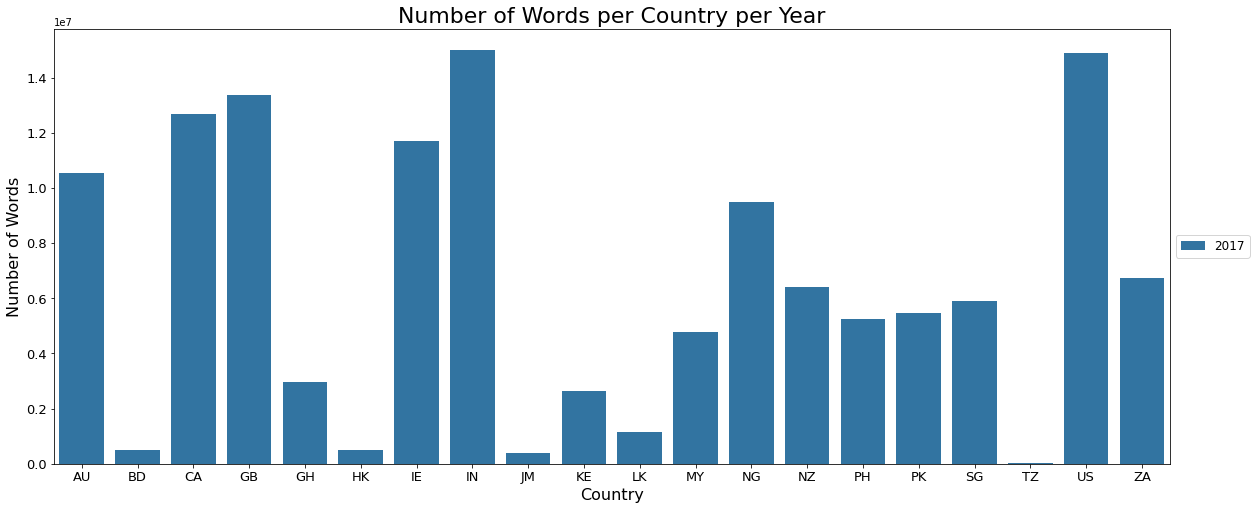

In [9]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(
    x="country", 
    y="total_words", 
    hue="year",
    data=summary_by_country_by_year,
    ax=ax
)
ax.set_xlabel("Country", fontsize=16)
ax.set_ylabel("Number of Words", fontsize=16)
ax.set_title("Number of Words per Country per Year", fontsize=22)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12);

In [11]:
summary_by_country_by_publisher = summary_stats_df.groupby(["country", "publisher"])
summary_by_country_by_publisher = summary_by_country_by_publisher[["num_articles", "total_words"]]
summary_by_country_by_publisher = summary_by_country_by_publisher.sum().reset_index()

summary_by_country_by_publisher

,country,publisher,num_articles,total_words
0,AU,3AW,15,5408
1,AU,4BC,2,1997
2,AU,6minutes,6,2310
3,AU,9Coach (blog),8,5050
4,AU,9Honey,75,31747
...,...,...,...,...
6070,ZA,journalism.co.za (blog),1,133
6071,ZA,ofm.co.za,93,22223
6072,ZA,theSouthAfrica,2,534
6073,ZA,www.sagoodnews.co.za,11,7696
